## 1. Problem Description

In this competition, the goal is to build a machine learning model that can predict which tweets are about real disasters and which ones are not.

### Model Architecture
I chose the LSTM-based neural network architecture for this problem because it is highly effective in handling sequential data like text, which is essential in Natural Language Processing (NLP) tasks such as text classification.

## 2. Load the Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
import nltk
from nltk.corpus import stopwords
import re
import string

# If you haven't downloaded NLTK data, uncomment the line below
# nltk.download('stopwords')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaunboerner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the training data
train_data = pd.read_csv('train.csv')

# Load the test data
test_data = pd.read_csv('test.csv')

# Preview the data
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 3. Exploratory Data Analysis (EDA)
### 3.1 Data Overview

In [3]:
# Check the shape of the data
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Check for missing values
train_data.isnull().sum()

Training data shape: (7613, 5)
Test data shape: (3263, 4)


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### 3.2 Visualizations

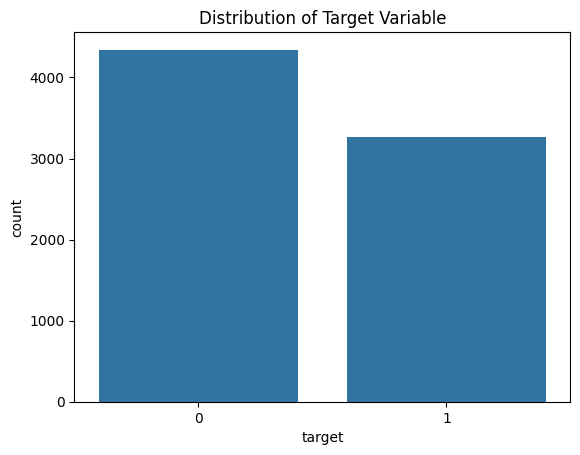

In [4]:
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()

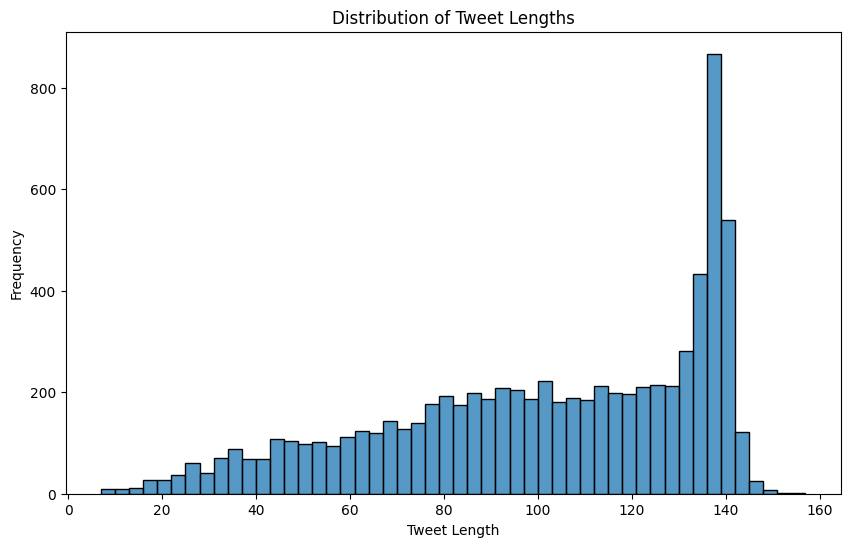

In [5]:
# Add a new column for tweet length
train_data['text_length'] = train_data['text'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(10,6))
sns.histplot(train_data['text_length'], bins=50)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

## 4. Data Cleaning and Preprocessing

In [6]:
# Function to clean the text data
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Lowercase the text
    text = text.lower()
    return text

# Apply the cleaning function to the text
train_data['clean_text'] = train_data['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
test_data['clean_text'] = test_data['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

## 5. Text to Sequences and Padding

In [7]:
# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['clean_text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['clean_text'])

# Padding sequences
max_length = 50
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

## 6. Model Building

### 6.1 Model Architecture

We’ll use an LSTM model since it is well-suited for sequential data like text.

In [8]:
# Define the model
model = models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=16, input_length=max_length),
    layers.Bidirectional(layers.LSTM(16, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(8)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 6.2 Training the Model

In [9]:
# Prepare target variable
y_train = train_data['target'].values

# Train-validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_padded, y_train, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5648 - loss: 0.6862 - val_accuracy: 0.5739 - val_loss: 0.6518
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6442 - loss: 0.6014 - val_accuracy: 0.7912 - val_loss: 0.4604
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8634 - loss: 0.3872 - val_accuracy: 0.7879 - val_loss: 0.4731
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9035 - loss: 0.2924 - val_accuracy: 0.7827 - val_loss: 0.5250
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9361 - loss: 0.2297 - val_accuracy: 0.7892 - val_loss: 0.5563
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9525 - loss: 0.1932 - val_accuracy: 0.7879 - val_loss: 0.6404
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9536 - loss: 0.1625 - val_accuracy: 0.7886 - val_loss: 0.6874
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9606 - loss: 0.1523 - val_accuracy: 0.7879 - v

## 7. Evaluation

### 7.1 Plotting Accuracy and Loss

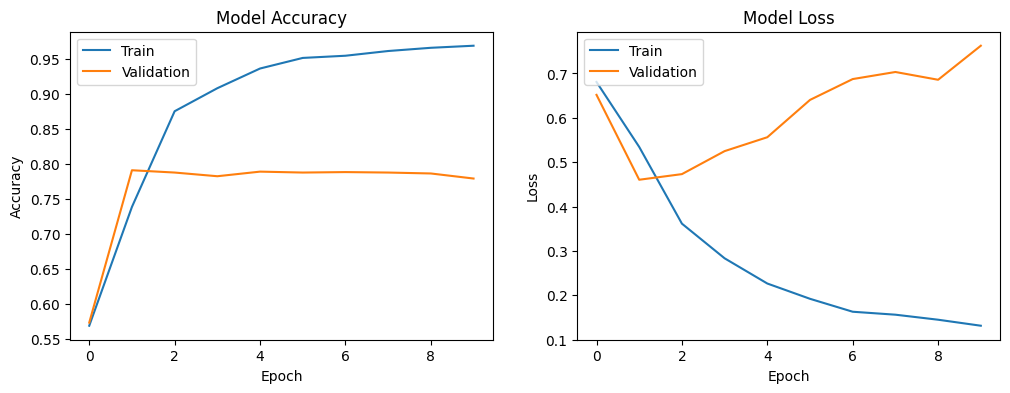

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 7.2 Evaluate on Validation Set

In [11]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.7794


## 8. Making Predictions and Submission

In [12]:
# Make predictions on test data
predictions = model.predict(test_padded)
predictions = (predictions > 0.5).astype(int).reshape(-1)

# Prepare submission file
submission = pd.read_csv('sample_submission.csv')
submission['target'] = predictions
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## 9. Conclusion

In this notebook, we’ve:
	•	Explored and cleaned the data.
	•	Converted text data into sequences suitable for modeling.
	•	Built and trained an LSTM-based neural network.
	•	Evaluated the model’s performance.

The model performend decently but didn't improve much and tappered off pretty uqickly after a few epohcs. 

## 10. Future Work

	•	Experiment with different architectures like GRU or Transformer models.
	•	Use pre-trained word embeddings like GloVe.
	•	Implement hyperparameter tuning using libraries like Keras Tuner.